<a href="https://colab.research.google.com/github/bhattadeb34/FACT_Data_Extraction_Scientific_Papers/blob/main/LLm_embeddings_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas sentence-transformers scikit-learn matplotlib seaborn umap-learn

In [2]:
!pip install openai

In [44]:
# Cell 1: Imports and Configuration (Modified)

import os
import re
import pandas as pd
import numpy as np
from openai import OpenAI
import google.generativeai as genai  # NEW: Import the Google AI library
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from collections import Counter

# --- Configuration ---
CSV_PATH = "master_conductivity_data.csv"
OUTPUT_FILENAME = "conductivity_pca_analysis.png"

# NEW: Choose your embedding provider here ("openai" or "gemini")
EMBEDDING_PROVIDER = "gemini"

# Select the model based on the provider
if EMBEDDING_PROVIDER == "openai":
    EMBEDDING_MODEL = "text-embedding-ada-002"
elif EMBEDDING_PROVIDER == "gemini":
    EMBEDDING_MODEL = "gemini-embedding-001"
# Configuration dictionary for models and their known dimensions
MODEL_CONFIG = {
    "text-embedding-ada-002": 1536,
    "gemini-embedding-001": 1536  # We will request this size for consistency
}

In [46]:
# Cell 2: API Key and Client Initialization (Modified)

api_key = None
client = None

if EMBEDDING_PROVIDER == "openai":
    try:
        from google.colab import userdata
        api_key = userdata.get('OPENAI_API_KEY')
        print("Retrieved OpenAI API key from Colab secrets.")
    except (ImportError, KeyError):
        print("Not in Colab, checking environment variable for OPENAI_API_KEY...")
        api_key = os.environ.get("OPENAI_API_KEY")
    if not api_key:
        raise ValueError("OpenAI API key not found.")
    client = OpenAI(api_key=api_key)
    print("OpenAI client initialized.")

elif EMBEDDING_PROVIDER == "gemini":
    try:
        from google.colab import userdata
        api_key = userdata.get('GOOGLE_API_KEY')
        print("Retrieved Google Gemini API key from Colab secrets.")
    except (ImportError, KeyError):
        print("Not in Colab, checking environment variable for GOOGLE_GEMINI_API_KEY...")
        api_key = os.environ.get("GOOGLE_GEMINI_API_KEY")
    if not api_key:
        raise ValueError("Google Gemini API key not found.")
    genai.configure(api_key=api_key)
    print("Google Gemini client configured.")

Retrieved Google Gemini API key from Colab secrets.
Google Gemini client configured.


In [49]:
# Cell 3: Helper Functions (Updated)

def _parse_temperature_value(value):
    """
    Parses a single temperature string into a numerical Celsius value.
    """
    if pd.isna(value): return np.nan
    value_str = str(value).lower()
    if 'rt' in value_str or 'room' in value_str: return 25.0
    if 'assumed' in value_str or 'not specified' in value_str: return np.nan
    numbers = re.findall(r'[-+]?\d*\.\d+|\d+', value_str)
    if numbers:
        temp = float(numbers[0])
        if temp > 200: return temp - 273.15
        return temp
    return np.nan

def clean_and_standardize_temperature(df: pd.DataFrame) -> pd.DataFrame:
    """
    Applies the temperature parsing logic to create a standardized 'temperature_celsius' column.
    """
    print("Standardizing temperature column...")
    df['temperature_celsius'] = df['temperature'].apply(_parse_temperature_value)
    parsed_count = df['temperature_celsius'].notna().sum()
    print(f"  -> Successfully parsed {parsed_count} / {len(df)} temperature entries.")
    return df

# In Cell 3 (Helper Functions)

def analyze_pca_by_word_correlation(df: pd.DataFrame, pca: PCA, provider: str, model_name: str, num_components: int = 2):
    """
    Analyzes PCA components by correlating them directly with the embeddings of
    individual words found within the dataset.
    """
    print("\n--- Interpreting PCA via Word-Component Correlation ---")

    stop_words = set(ENGLISH_STOP_WORDS)
    custom_stop_words = {'material', 'description', 'processing', 'method', 'na'}
    stop_words.update(custom_stop_words)

    interpretation_df = df[~df['material_description'].str.contains("Cited Work", na=False)]
    if interpretation_df.empty:
        print("Warning: No primary data found for interpretation.")
        return

    all_text = ' '.join(interpretation_df['feature_text'])
    words = set(re.findall(r'\b[a-zA-Z]{3,}\b', all_text.lower()))
    vocabulary = sorted([word for word in words if word not in stop_words])
    print(f"Built a vocabulary of {len(vocabulary)} unique terms from the data.")

    # MODIFIED: Use the generic dispatcher function instead of the OpenAI-specific one
    vocab_embeddings = get_embeddings(provider, model_name, vocabulary)

    for i in range(num_components):
        component_vector = pca.components_[i]
        alignment_scores = np.dot(vocab_embeddings, component_vector)
        sorted_indices = np.argsort(alignment_scores)

        positive_pole_words = [vocabulary[j] for j in sorted_indices[-5:][::-1]]
        negative_pole_words = [vocabulary[j] for j in sorted_indices[:5]]

        print(f"\n[+] Component {i+1} appears to distinguish between:")
        print(f"    - High values (Positive Pole) are defined by: {positive_pole_words}")
        print(f"    - Low values (Negative Pole) are defined by: {negative_pole_words}")

In [51]:
# Cell 3: Helper Functions (Modified)

# --- (Your _parse_temperature_value and clean_and_standardize_temperature functions remain here) ---

def get_openai_embeddings(texts: list[str], client: OpenAI, model_name: str, batch_size: int = 500) -> np.ndarray:
    """Generates embeddings using OpenAI's API."""
    embedding_dim = MODEL_CONFIG.get(model_name, 1536) # Default to 1536 if unknown
    all_embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc=f"Generating {model_name} Embeddings"):
        batch = texts[i:i + batch_size]
        try:
            response = client.embeddings.create(input=batch, model=model_name)
            embeddings = [item.embedding for item in response.data]
            all_embeddings.extend(embeddings)
        except Exception as e:
            print(f"An error occurred: {e}")
            all_embeddings.extend([[0] * embedding_dim] * len(batch))
    return np.array(all_embeddings)

def get_gemini_embeddings(texts: list[str], model_name: str, batch_size: int = 100) -> np.ndarray:
    """
    Generates embeddings using Gemini's API, following recommended practices.
    """
    embedding_dim = MODEL_CONFIG.get(model_name, 1536)
    all_embeddings = []

    for i in tqdm(range(0, len(texts), batch_size), desc=f"Generating {model_name} Embeddings"):
        batch = texts[i:i + batch_size]
        try:
            # Recommended practice: Specify task_type and output_dimensionality [cite: 1149, 1207]
            result = genai.embed_content(
                model=model_name,
                content=batch,
                task_type="SEMANTIC_SIMILARITY",
                output_dimensionality=embedding_dim
            )

            # Recommended practice: Normalize embeddings for dimensions other than 3072 [cite: 1229]
            for embedding in result['embedding']:
                embedding_np = np.array(embedding)
                normed_embedding = embedding_np / np.linalg.norm(embedding_np)
                all_embeddings.append(normed_embedding)

        except Exception as e:
            print(f"An error occurred: {e}")
            all_embeddings.extend([[0] * embedding_dim] * len(batch))

    return np.array(all_embeddings)

def get_embeddings(provider: str, model_name: str, texts: list[str]) -> np.ndarray:
    """Dispatcher function to call the correct embedding service."""
    if provider == "openai":
        return get_openai_embeddings(texts, client, model_name)
    elif provider == "gemini":
        return get_gemini_embeddings(texts, model_name)
    else:
        raise ValueError(f"Unknown provider: {provider}. Choose 'openai' or 'gemini'.")


In [6]:
# Load the master CSV
df = pd.read_csv(CSV_PATH)
print(f"Loaded {len(df)} total data points from CSV.")

Loaded 3790 total data points from CSV.


In [7]:
df.head(5)

,paper_title,paper_doi,paper_authors,full_name,acronym,material_class,ionic_conductivity_S_per_cm,temperature,processing_method,material_description,source_location
0,Preparation of high ionic conductivity composi...,https://doi.org/10.1016/j.electacta.2022.141155),als.elsevier.com/electrochimica-acta ![](_page...,Polyethylene oxide / Lithium Bis(trifluorometh...,PLZ-20 (PEO/LiTFSI/LLZO@ZiF-67),Other,0.000109,RT,LLZO@ZiF-67 inorganic filler was synthesized t...,High performance composite solid electrolyte m...,Abstract
1,Preparation of high ionic conductivity composi...,https://doi.org/10.1016/j.electacta.2022.141155),als.elsevier.com/electrochimica-acta ![](_page...,Polyethylene oxide / Gallium-doped Lithium Lan...,PEO:Ga-LLZO,Other,0.000072,30 °C,N/A (Cited Work),N/A (Cited Work),"Main text, page 1, paragraph 4 (citing Ref [21])"
2,Preparation of high ionic conductivity composi...,https://doi.org/10.1016/j.electacta.2022.141155),als.elsevier.com/electrochimica-acta ![](_page...,Poly(vinylidene fluoride-hexafluoropropylene) ...,PVDF-HFP/LLZO,Other,0.000950,RT,N/A (Cited Work),N/A (Cited Work),"Main text, page 1, paragraph 4 (citing Ref [22])"
3,Preparation of high ionic conductivity composi...,https://doi.org/10.1016/j.electacta.2022.141155),als.elsevier.com/electrochimica-acta ![](_page...,Polyethylene oxide / Lithium Bis(trifluorometh...,LLZAO-PEO/LiTFSI,Other,0.000251,RT,N/A (Cited Work),N/A (Cited Work),"Main text, page 1, paragraph 4 (citing Ref [23])"
4,Preparation of high ionic conductivity composi...,https://doi.org/10.1016/j.electacta.2022.141155),als.elsevier.com/electrochimica-acta ![](_page...,Polyethylene oxide / Lithium Bis(trifluorometh...,PLZ-20 (PEO/LiTFSI/LLZO@ZiF-67),Other,0.000109,RT,LLZO@ZiF-67 inorganic filler was synthesized t...,Composite electrolyte synthesized by filling L...,"Main text, page 1, paragraph 5"


In [8]:
# --- NEW STEP 1: Clean DOIs and Deduplicate Papers ---
# This step ensures each paper is only represented once in our analysis dataset.
df['paper_doi_cleaned'] = df['paper_doi'].str.extract(r'(https://doi\.org/[\S]+)')
df.dropna(subset=['paper_doi_cleaned'], inplace=True)
unique_papers_before = df['paper_doi_cleaned'].nunique()
# We keep the first set of entries for each unique paper
df_unique_papers = df.drop_duplicates(subset=['paper_doi_cleaned'], keep='first').copy()
print(f"Filtered down to {len(df_unique_papers)} entries representing {unique_papers_before} unique papers.")
# ---


Filtered down to 101 entries representing 101 unique papers.


In [27]:
# --- NEW STEP 2: Clean and FILTER for Room Temperature ---
# We will now work with the deduplicated DataFrame
df_cleaned = clean_and_standardize_temperature(df_unique_papers)


Standardizing temperature column...
  -> Successfully parsed 100 / 101 temperature entries.


In [28]:
# Create a new DataFrame containing ONLY room temperature data (20-30°C)
rt_df = df_cleaned[(df_cleaned['temperature_celsius'] >= 20) & (df_cleaned['temperature_celsius'] <= 30)].copy()
print(f"Further filtered to {len(rt_df)} data points measured at Room Temperature (20-30°C).")

Further filtered to 95 data points measured at Room Temperature (20-30°C).


In [36]:
print(df['temperature'].unique())

['RT' '30 °C' '25 °C' '25°C' '35°C' '45°C' '55°C' '70°C' '20 \x08°C'
 '30 \x08°C' 'Not specified' 'room temperature' 'RT (25 °C)' '40 °C'
 '71.7°C (344.8K)' '29.9°C (303.0K)' '55 \x08\tC' '25 \x08\tC'
 '30 \x08\tC' '22 \x08\tC' '300 K' '20 °C' 'Room-temperature' '~24 °C'
 'N/A (General statement)' '22.5 °C' '2.5 °C' '6.0 °C' '70 °C'
 'N/A (Cited Work)' 'Not specified in figure' '50 °C' '45 °C' '37 °C'
 '35 °C' '84.0°C (357.1K)' '80°C' '60°C' '40°C' '27 °C' '24 °C' '28 °C'
 '21 °C' '30°C' '20°C' '100°C' '21°C' '4°C' '28°C' 'Room Temperature'
 'ambient temperature' '30 °C (303 K)' '84 °C (357 K)'
 'RT (implied, general statement)' '25 °C (room temperature)'
 'Room temperature' '25 ℃' '20 ℃' '50°C'
 'Not specified, assumed to be room temperature relevant' '~21 °C (294 K)'
 '~60 °C (333 K)' '25 \x08°C' '100 \x08°C' 'AT'
 '25°C (estimated from 1000/T = 3.35)' '18°C' '25°C or RT'
 'RT (Assumed for filler particle intrinsic conductivity)'
 'Not specified; Measurement at 20% Relative Humidity'

In [38]:
print(rt_df['temperature_celsius'].unique())

[25.   20.   26.85 30.   27.  ]


In [53]:
if not rt_df.empty:
    # Create the feature text for embedding using only the RT data
    rt_df['feature_text'] = (
        "Material: " + rt_df['full_name'].fillna('') +
        ". Description: " + rt_df['material_description'].fillna('') +
        ". Processing: " + rt_df['processing_method'].fillna('')
    )

    # --- THIS IS THE ONLY CALL YOU NEED ---
    # Generate embeddings using the dispatcher function
    embeddings = get_embeddings(
        provider=EMBEDDING_PROVIDER,
        model_name=EMBEDDING_MODEL,
        texts=rt_df['feature_text'].tolist()
    )
    # ------------------------------------

    # Filter out any rows where embedding might have failed
    valid_mask = np.all(embeddings != 0, axis=1)
    rt_df = rt_df[valid_mask].copy()
    embeddings = embeddings[valid_mask]

    print(f"\nSuccessfully generated embeddings for {len(rt_df)} room temperature data points.")
else:
    print("\nNo room temperature data found after filtering. Cannot proceed with embedding.")

# The 'rt_df' DataFrame is now ready for the next cell (PCA and visualization)

Generating gemini-embedding-001 Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]


Successfully generated embeddings for 95 room temperature data points.


In [54]:
# Cell 5: Perform PCA and Interpret Results (Corrected)

# Perform PCA on the embeddings of the filtered room-temperature data
print("\nReducing embedding dimensions with PCA...")
pca = PCA(n_components=2, random_state=42)
embeddings_2d = pca.fit_transform(embeddings)

# Add PCA columns to the 'rt_df' DataFrame
rt_df['pca_1'] = embeddings_2d[:, 0]
rt_df['pca_2'] = embeddings_2d[:, 1]

# --- NEW: Programmatic Log Calculation ---
# First, try to calculate the log directly
# We temporarily suppress the "divide by zero" warning that numpy will raise for log(0)
with np.errstate(divide='ignore'):
    log_values = np.log10(rt_df['ionic_conductivity_S_per_cm'].values)

# Check if the operation produced any -inf values (the result of log(0))
if np.isneginf(log_values).any():
    print("Warning: Zero or non-positive conductivity values found. Adding a small constant for log scaling.")
    # If -inf exists, recalculate by adding a small constant to ensure numerical stability
    rt_df['log_conductivity'] = np.log10(rt_df['ionic_conductivity_S_per_cm'] + 1e-15)
else:
    # If no errors occurred, use the directly calculated values
    rt_df['log_conductivity'] = log_values
# --- END NEW LOGIC ---

# Run the updated analysis function, passing in the correct DataFrame and arguments
analyze_pca_by_word_correlation(rt_df, pca, EMBEDDING_PROVIDER, EMBEDDING_MODEL)


Reducing embedding dimensions with PCA...

--- Interpreting PCA via Word-Component Correlation ---
Built a vocabulary of 796 unique terms from the data.


Generating gemini-embedding-001 Embeddings:   0%|          | 0/8 [00:00<?, ?it/s]


[+] Component 1 appears to distinguish between:
    - High values (Positive Pole) are defined by: ['polymerization', 'polymerized', 'drying', 'electrospinning', 'copolymerization']
    - Low values (Negative Pole) are defined by: ['cited', 'unspecified', 'orthosilicate', 'generic', 'zirconate']

[+] Component 2 appears to distinguish between:
    - High values (Positive Pole) are defined by: ['polyoxyethylene', 'polymer', 'copolymer', 'polyethylene', 'trifluoromethanesulfonimide']
    - Low values (Negative Pole) are defined by: ['llzo', 'llto', 'zirconia', 'llzto', 'lanthanum']



Creating visualization and saving to 'conductivity_pca_analysis.png'...
Done.


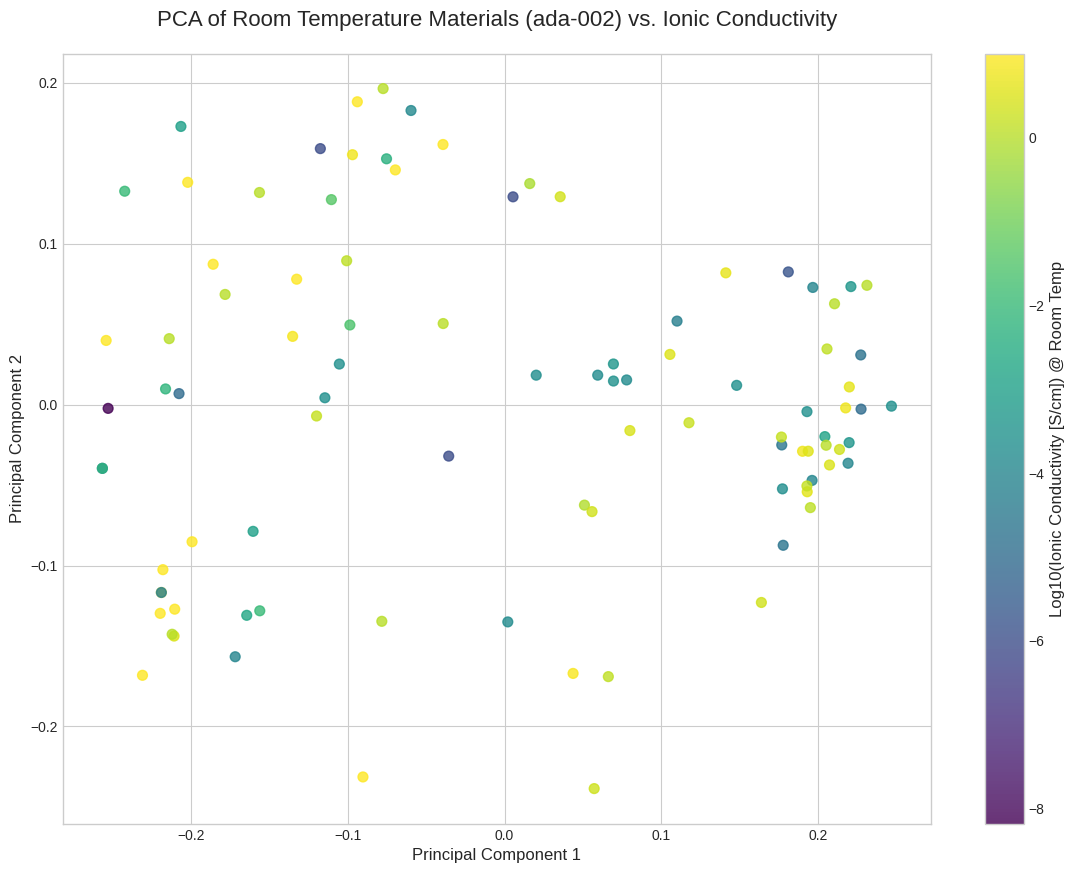

In [55]:
# Cell 6: Visualize and Save the Plot (Corrected)

# Create and save the final visualization using the 'rt_df' DataFrame
print(f"\nCreating visualization and saving to '{OUTPUT_FILENAME}'...")
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(14, 10))

scatter = ax.scatter(
    x=rt_df['pca_1'], y=rt_df['pca_2'], c=rt_df['log_conductivity'],
    cmap='viridis', s=50, alpha=0.8
)

cbar = plt.colorbar(scatter)
cbar.set_label('Log10(Ionic Conductivity [S/cm]) @ Room Temp', fontsize=12) # Updated label for clarity

ax.set_title('PCA of Room Temperature Materials (ada-002) vs. Ionic Conductivity', fontsize=16, pad=20) # Updated title
ax.set_xlabel('Principal Component 1', fontsize=12)
ax.set_ylabel('Principal Component 2', fontsize=12)

plt.savefig(OUTPUT_FILENAME, dpi=300, bbox_inches='tight')
print("Done.")
plt.show()

# Train ML model

In [57]:
!pip install xgboost

In [61]:
# In Cell 1, add these new imports
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge, BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.cross_decomposition import PLSRegression
import xgboost as xgb

In [62]:
# Define the features (X) and the target (y) from your cleaned, room-temperature DataFrame
X = embeddings
y = rt_df['log_conductivity'].values

# Create a dictionary of all the models we want to test
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(alpha=0.1, random_state=42),
    "Ridge": Ridge(alpha=1.0, random_state=42),
    "Bayesian Ridge": BayesianRidge(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "SVR": SVR(kernel='rbf'),
    "PLS Regression": PLSRegression(n_components=10),
    "XGBoost": xgb.XGBRegressor(objective='reg:squarederror', n_estimators=500, random_state=42)
}

In [63]:
# Set up 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

results = []

print("Running 5-fold cross-validation for each model...")
for name, model in tqdm(models.items(), desc="Validating Models"):
    # Calculate R-squared scores
    r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')

    # Calculate Mean Absolute Error scores
    mae_scores = -cross_val_score(model, X, y, cv=kf, scoring='neg_mean_absolute_error')

    results.append({
        "Model": name,
        "Mean R2": np.mean(r2_scores),
        "Std R2": np.std(r2_scores),
        "Mean MAE": np.mean(mae_scores),
        "Std MAE": np.std(mae_scores)
    })

# Display the results in a clean DataFrame
results_df = pd.DataFrame(results).sort_values(by="Mean R2", ascending=False).reset_index(drop=True)
print("\n--- Cross-Validation Performance Summary ---")
display(results_df)

Running 5-fold cross-validation for each model...


Validating Models:   0%|          | 0/8 [00:00<?, ?it/s]


--- Cross-Validation Performance Summary ---


,Model,Mean R2,Std R2,Mean MAE,Std MAE
0,Ridge,-0.044036,0.064463,2.135759,0.141064
1,Bayesian Ridge,-0.057135,0.057896,2.150372,0.155448
2,Lasso,-0.058752,0.051336,2.151515,0.157063
3,Random Forest,-0.123679,0.175593,2.140129,0.084112
4,SVR,-0.323720,0.184516,2.020698,0.325650
5,XGBoost,-0.567846,0.466538,2.404936,0.152374
6,PLS Regression,-1.046723,0.587735,2.637630,0.172080
7,Linear Regression,-1.329516,0.822808,2.790847,0.190081



--- Generating Actual vs. Predicted Plots for Test Set ---


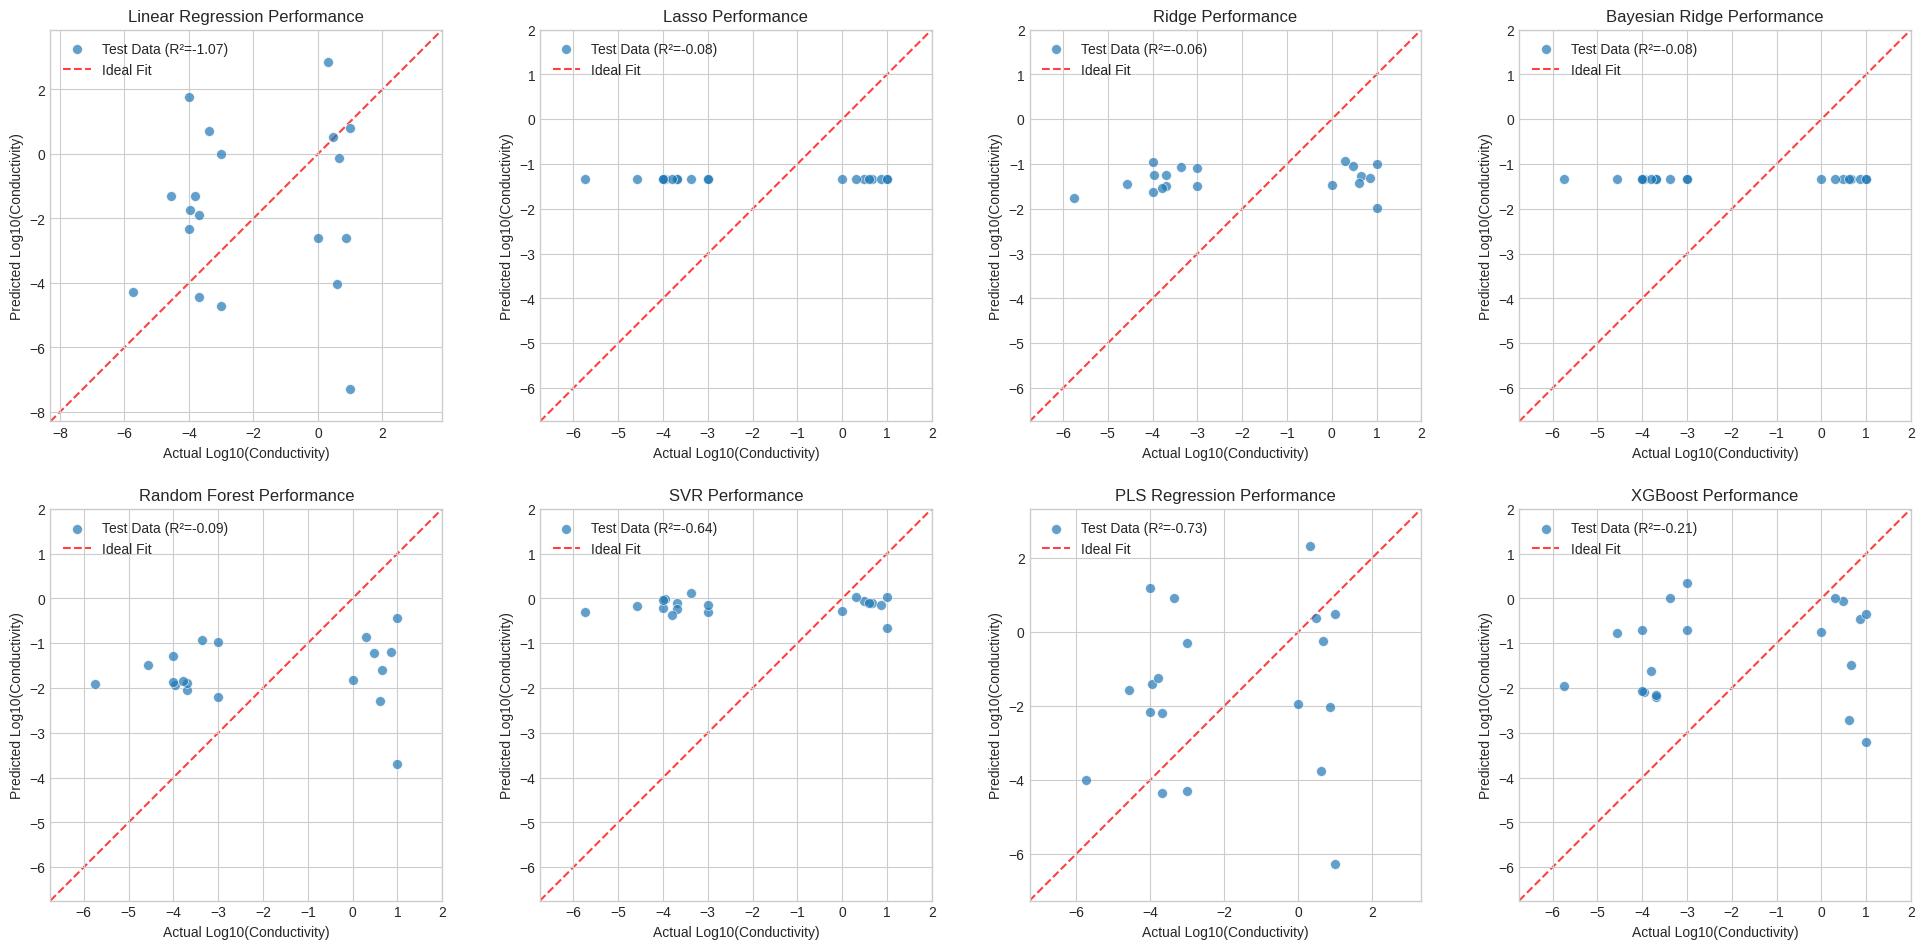

In [66]:
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Split the data one time for consistent visualization
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the 2x4 subplot grid
fig, axes = plt.subplots(2, 4, figsize=(20, 10)) # MODIFIED: Changed layout and size
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

print("\n--- Generating Actual vs. Predicted Plots for Test Set ---")
for i, (name, model) in enumerate(models.items()):
    ax = axes[i]

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate test score
    test_r2 = r2_score(y_test, y_pred)

    # Create scatter plot
    sns.scatterplot(x=y_test, y=y_pred, ax=ax, alpha=0.7, s=50, label=f'Test Data (R²={test_r2:.2f})')

    # Plot the ideal fit line (y=x)
    lims = [min(y_test.min(), y_pred.min()) - 1, max(y_test.max(), y_pred.max()) + 1]
    ax.plot(lims, lims, 'r--', alpha=0.75, zorder=0, label='Ideal Fit')
    ax.set_xlim(lims)
    ax.set_ylim(lims)

    ax.set_title(f"{name} Performance", fontsize=12)
    ax.set_xlabel("Actual Log10(Conductivity)")
    ax.set_ylabel("Predicted Log10(Conductivity)")
    ax.set_aspect('equal', adjustable='box')
    ax.legend(loc='upper left')

# Adjust layout and display the plot
plt.tight_layout(pad=3.0)
plt.show()

In [67]:
# Cell: Predict on New, Hypothetical Materials (Corrected)

# --- 1. Automatically Select the Best Model ---
# Find the model with the highest Mean R-squared from our cross-validation results
best_model_name = results_df.loc[results_df['Mean R2'].idxmax()]['Model']
best_model = models[best_model_name]
print(f"Selected the best model based on cross-validation: '{best_model_name}'")

# --- 2. Retrain the Best Model on the Entire Dataset ---
# For final predictions, it's best practice to train the model on all available data
print(f"Retraining '{best_model_name}' on the full dataset...")
best_model.fit(X, y)
print("Model retraining complete.")

# --- 3. Define Hypothetical Materials and Get Embeddings ---
hypothetical_material_1 = "Material: Ga-doped LLZO. Description: Dense ceramic pellet with cubic garnet phase. Processing: High-temperature sintering at 1200°C for 5 hours."
hypothetical_material_2 = "Material: PEO with LiTFSI. Description: Amorphous polymer film. Processing: Solution casting followed by drying in vacuum at 60°C."
hypothetical_materials = [hypothetical_material_1, hypothetical_material_2]

# Use the generic dispatcher function to get embeddings
new_embeddings = get_embeddings(
    provider=EMBEDDING_PROVIDER,
    model_name=EMBEDDING_MODEL,
    texts=hypothetical_materials
)

# --- 4. Make Predictions with the Best Model ---
predicted_log_conductivities = best_model.predict(new_embeddings)

# Convert log conductivity back to standard scientific notation for easier interpretation
predicted_conductivities = [10**log_val for log_val in predicted_log_conductivities]

# --- 5. Print the Results ---
print("\n--- Predictions for Hypothetical Materials ---")
print(f"Using model: {best_model_name}")
print("-" * 40)
print(f"Material 1 (LLZO):")
print(f"  - Predicted Log Conductivity: {predicted_log_conductivities[0]:.2f}")
print(f"  - Predicted Conductivity (S/cm): {predicted_conductivities[0]:.2e}")
print("-" * 40)
print(f"Material 2 (PEO):")
print(f"  - Predicted Log Conductivity: {predicted_log_conductivities[1]:.2f}")
print(f"  - Predicted Conductivity (S/cm): {predicted_conductivities[1]:.2e}")

Selected the best model based on cross-validation: 'Ridge'
Retraining 'Ridge' on the full dataset...
Model retraining complete.


Generating gemini-embedding-001 Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]


--- Predictions for Hypothetical Materials ---
Using model: Ridge
----------------------------------------
Material 1 (LLZO):
  - Predicted Log Conductivity: -1.28
  - Predicted Conductivity (S/cm): 5.31e-02
----------------------------------------
Material 2 (PEO):
  - Predicted Log Conductivity: -2.19
  - Predicted Conductivity (S/cm): 6.39e-03
